<a href="https://colab.research.google.com/github/bibinmjose/causal-donelly/blob/original/3_amazon_prime_dags.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab may need these packages installed
!apt install libgraphviz-dev
!pip install pygraphviz
%pip install dowhy graphviz pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 5 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main 

In [ ]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import seaborn as sns
import graphviz as gr
import statsmodels.formula.api as smf
from tqdm import trange
from dowhy import CausalModel

mpl.rcParams['figure.figsize'] = [25, 10]

In [ ]:
def simulate(**kwargs):
  values = {}
  for k,v in kwargs.items():
    inputs = {arg: values[arg] for arg in v.__code__.co_varnames}
    values[k] = v(**inputs)
  return pd.DataFrame(values)

# Rule 1: Controlling for confounders

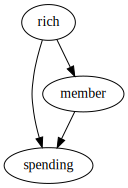

In [ ]:
g = gr.Digraph()
g.edge("rich", "spending")
g.edge("rich", "member")
g.edge("member", "spending")
g

In [ ]:
true_effect = 50
np.random.seed(0)

def get_data_1(N):
  return simulate(
      rich = lambda: np.random.binomial(1, 0.05, N),
      member = lambda rich: np.random.binomial(1, 0.20 + 0.20*rich, N),
      spending = lambda rich, member: 
        200*rich + true_effect*member + np.random.normal(500,100,N),
  )
df = get_data_1(100000)

In [ ]:
def diff_means(df):
  return df[df.member == 1].spending.mean() \
    - df[df.member == 0].spending.mean() 

def diff_means_by_group(df, group_var):
  group_1 = df[df[group_var] == 1]
  group_0 = df[df[group_var] == 0]
  
  group_1_mean = diff_means(group_1)
  group_0_mean = diff_means(group_0)

  group_1_frac = df[group_var].mean()

  return group_1_mean * group_1_frac + group_0_mean * (1-group_1_frac)

In [ ]:
df.groupby('member').spending.mean()

member
0    506.916605
1    569.498003
Name: spending, dtype: float64

In [ ]:
df.groupby('rich').apply(diff_means)

rich
0    51.260069
1    45.036126
dtype: float64

In [ ]:
# Do regression without controlling for rich
result = smf.ols('spending ~ member', data=df).fit()
print(result.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    506.9166      0.388   1306.360      0.000     506.156     507.677
member        62.5814      0.843     74.259      0.000      60.930      64.233


In [ ]:
# Do regression controlling for rich
result = smf.ols('spending ~ rich*member', data=df).fit()
print(result.summary().tables[1])

                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     499.3647      0.363   1375.528      0.000     498.653     500.076
rich          202.2702      1.879    107.658      0.000     198.588     205.953
member         51.2601      0.808     63.406      0.000      49.676      52.845
rich:member    -6.2239      2.992     -2.080      0.037     -12.088      -0.360


### What distribution of predictions would we get if we repeated the process many times?

In [ ]:
N_obs = 1000
N_sims = 1000

100%|██████████| 1000/1000 [00:01<00:00, 758.38it/s]


Nobs: 1000, Nsim: 1000
Mean: 61.71980112932956, SD: 9.134759184207491


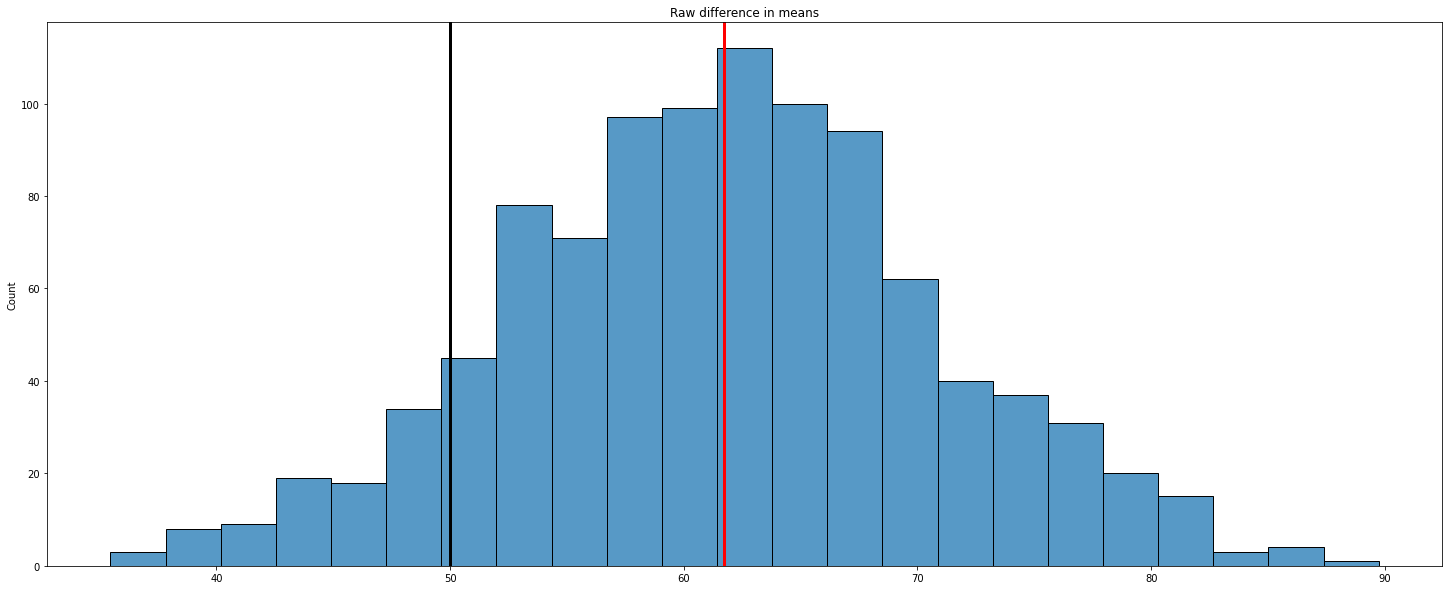

In [ ]:
# We do not learn the true effect of membership if we look at the raw difference in means
outputs = [diff_means(get_data_1(N_obs)) for _ in trange(N_sims)]
fig = sns.histplot(outputs)
fig.set_title("Raw difference in means") 
fig.axvline(np.mean(outputs), color="red", linewidth=3)
fig.axvline(true_effect, color="black", linewidth=3)
print(f"Nobs: {N_obs}, Nsim: {N_sims}")
print(f"Mean: {np.mean(outputs)}, SD: {np.std(outputs)}")

100%|██████████| 1000/1000 [00:02<00:00, 342.84it/s]


Nobs: 1000, Nsim: 1000
Mean: 50.263598842171454, SD: 7.742673557781935


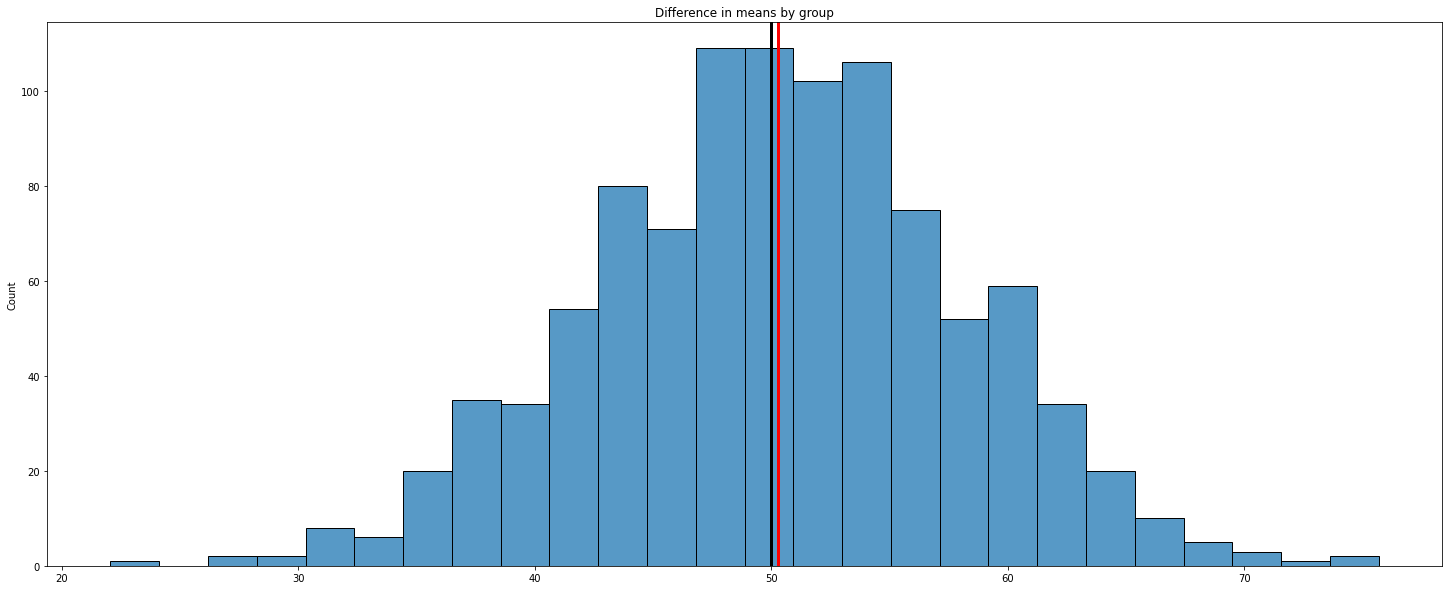

In [ ]:
# But we do if we calculate the effect of membership seperately for each group
outputs = [diff_means_by_group(get_data_1(N_obs), "rich") for _ in trange(N_sims)]
fig = sns.histplot(outputs)
fig.set_title("Difference in means by group")
fig.axvline(np.mean(outputs), color="red", linewidth=3)
fig.axvline(true_effect, color="black", linewidth=3)
print(f"Nobs: {N_obs}, Nsim: {N_sims}")
print(f"Mean: {np.mean(outputs)}, SD: {np.std(outputs)}")

# Rule 2: Don't control for mediators

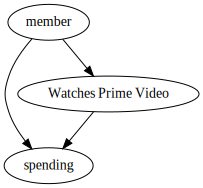

In [ ]:
g = gr.Digraph()
g.edge("member", "spending")
g.edge("member", "Watches Prime Video")
g.edge("Watches Prime Video", "spending")
g

In [ ]:
direct_effect = 50
increase_in_video_prob = 0.20
video_effect = 50

total_effect = true_effect + video_effect*increase_in_video_prob

def get_data_2(N):
  return simulate(
      member = lambda: np.random.binomial(1, 0.20, N),
      video = lambda member: np.random.binomial(1, 0.05 + increase_in_video_prob*member, N),
      spending = lambda member, video: 
        true_effect*member + video_effect*video + np.random.normal(500,100,N),
  )
df = get_data_2(1000)

In [ ]:
N_obs = 10000
N_sims = 1000

100%|██████████| 1000/1000 [00:02<00:00, 409.66it/s]


Nobs: 10000, Nsim: 1000
Mean: 60.14619127820493, SD: 2.52518577646744
Total effect: 60.0, Direct Effect 50


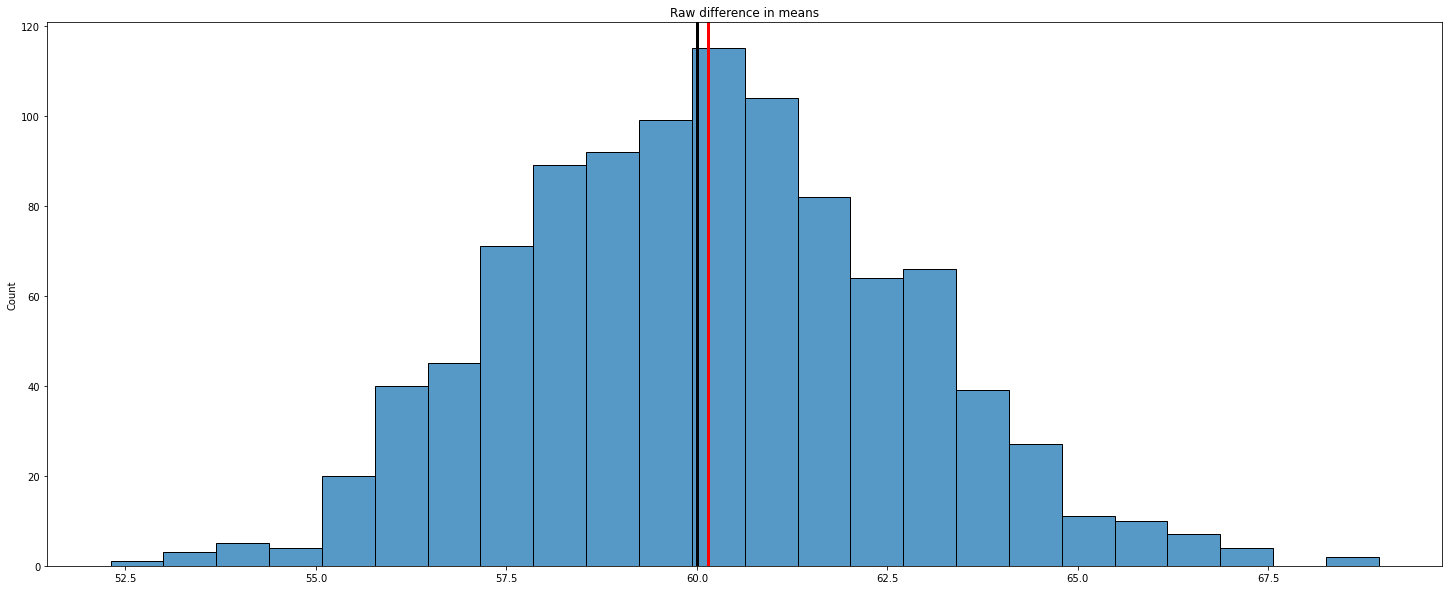

In [ ]:
# If we look at raw difference in means, then we estimate the full effect of membership on spending
outputs = [diff_means(get_data_2(N_obs)) for _ in trange(N_sims)]
fig = sns.histplot(outputs)
fig.set_title("Raw difference in means") 
fig.axvline(np.mean(outputs), color="red", linewidth=3)
fig.axvline(total_effect, color="black", linewidth=3)
print(f"Nobs: {N_obs}, Nsim: {N_sims}")
print(f"Mean: {np.mean(outputs)}, SD: {np.std(outputs)}")
print(f"Total effect: {total_effect}, Direct Effect {direct_effect}")

100%|██████████| 1000/1000 [00:04<00:00, 244.39it/s]


Nobs: 10000, Nsim: 1000
Mean: 50.04011372317976, SD: 2.7429512447158024
Total effect: 60.0, Direct Effect 50


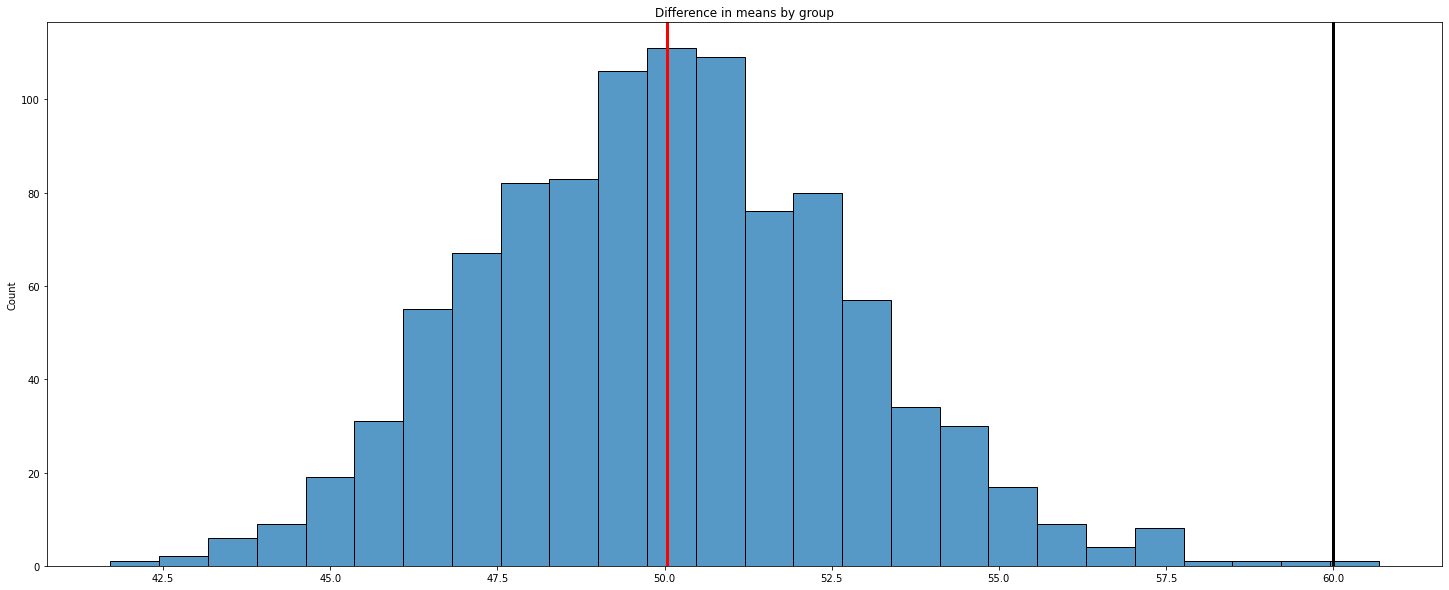

In [ ]:
# If we control for video, then we estimate only the direct effect of membership
outputs = [diff_means_by_group(get_data_2(N_obs), "video") for _ in trange(N_sims)]
fig = sns.histplot(outputs)
fig.set_title("Difference in means by group")
fig.axvline(np.mean(outputs), color="red", linewidth=3)
fig.axvline(total_effect, color="black", linewidth=3)
print(f"Nobs: {N_obs}, Nsim: {N_sims}")
print(f"Mean: {np.mean(outputs)}, SD: {np.std(outputs)}")
print(f"Total effect: {total_effect}, Direct Effect {direct_effect}")

# Rule 3: Controlling for outcome predictors

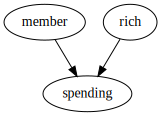

In [ ]:
g = gr.Digraph()
g.edge("member", "spending")
g.edge("rich", "spending")
g

In [ ]:
def get_data_3(N):
  return simulate(
      rich = lambda: np.random.binomial(1, 0.05, N),
      member = lambda: np.random.binomial(1, 0.20, N),
      spending = lambda rich, member: 
        10000*rich + true_effect*member + np.random.normal(500,100,N),
  )
df = get_data_3(1000)

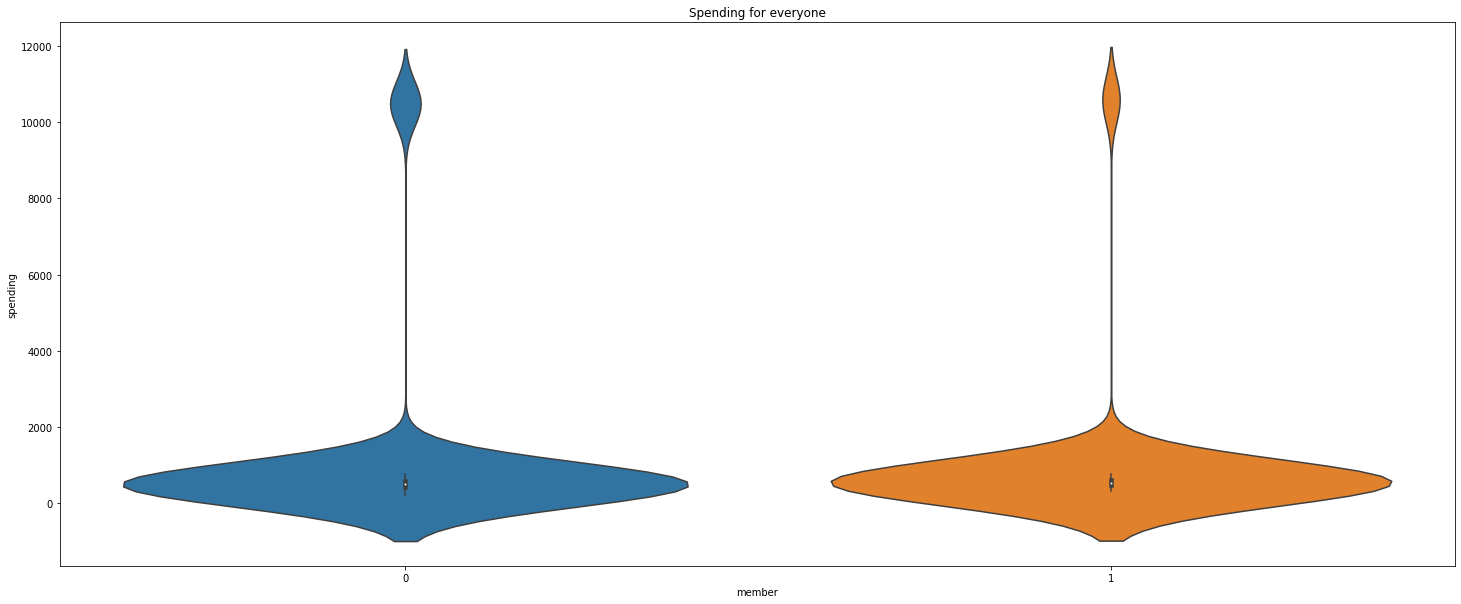

In [ ]:
fig = sns.violinplot(data=df, x='member', y='spending')
fig.set_title("Spending for everyone")
fig.plot()

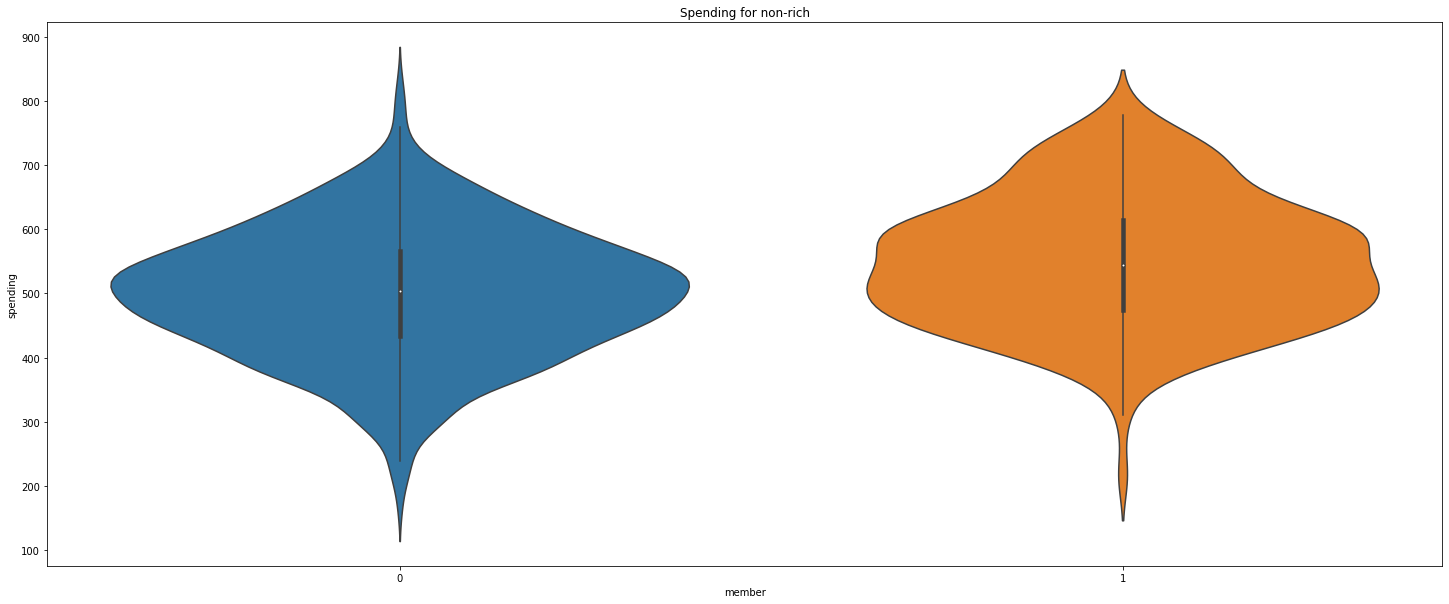

In [ ]:
fig = sns.violinplot(data=df[df.rich == 0], x='member', y='spending')
fig.set_title("Spending for non-rich")
fig.plot()

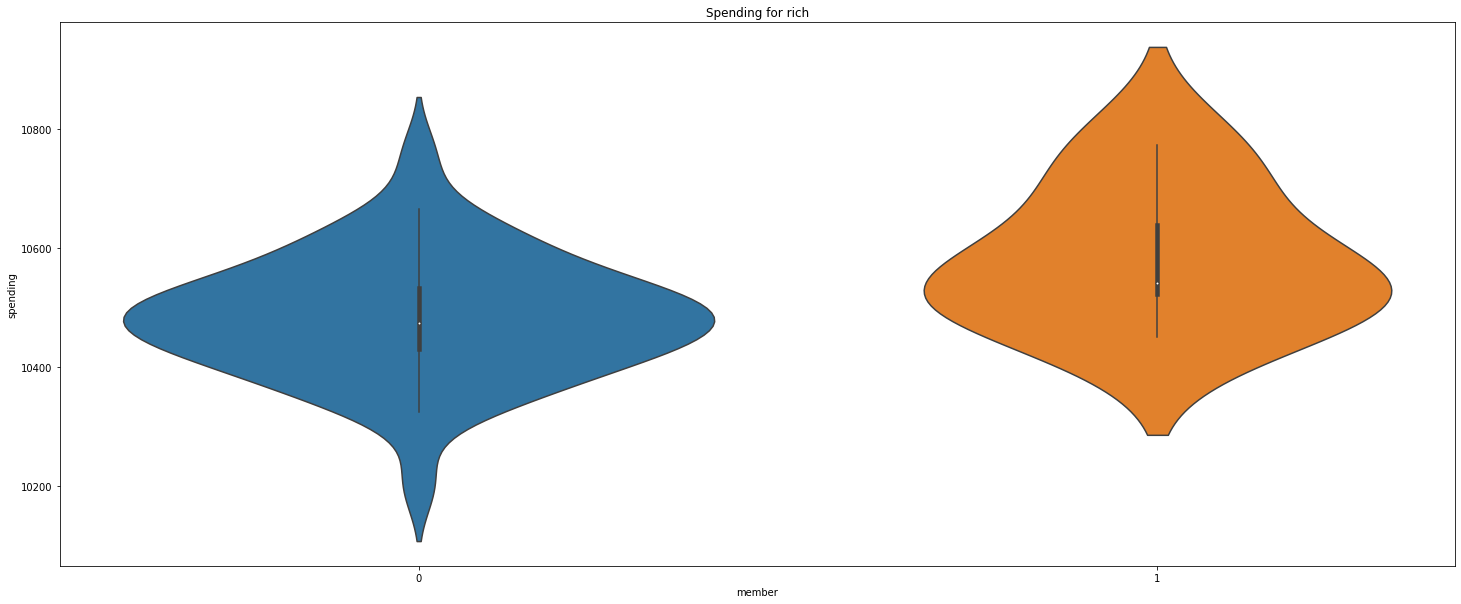

In [ ]:
fig = sns.violinplot(data=df[df.rich == 1], x='member', y='spending')
fig.set_title("Spending for rich")
fig.plot()

### What distribution of predictions would we get if we repeated the process many times?


In [ ]:
N_obs = 1000
N_sims = 1000

100%|██████████| 1000/1000 [00:01<00:00, 583.50it/s]


Nobs: 1000, Nsim: 1000
Mean: 41.160792090303715, SD: 164.8855941505706


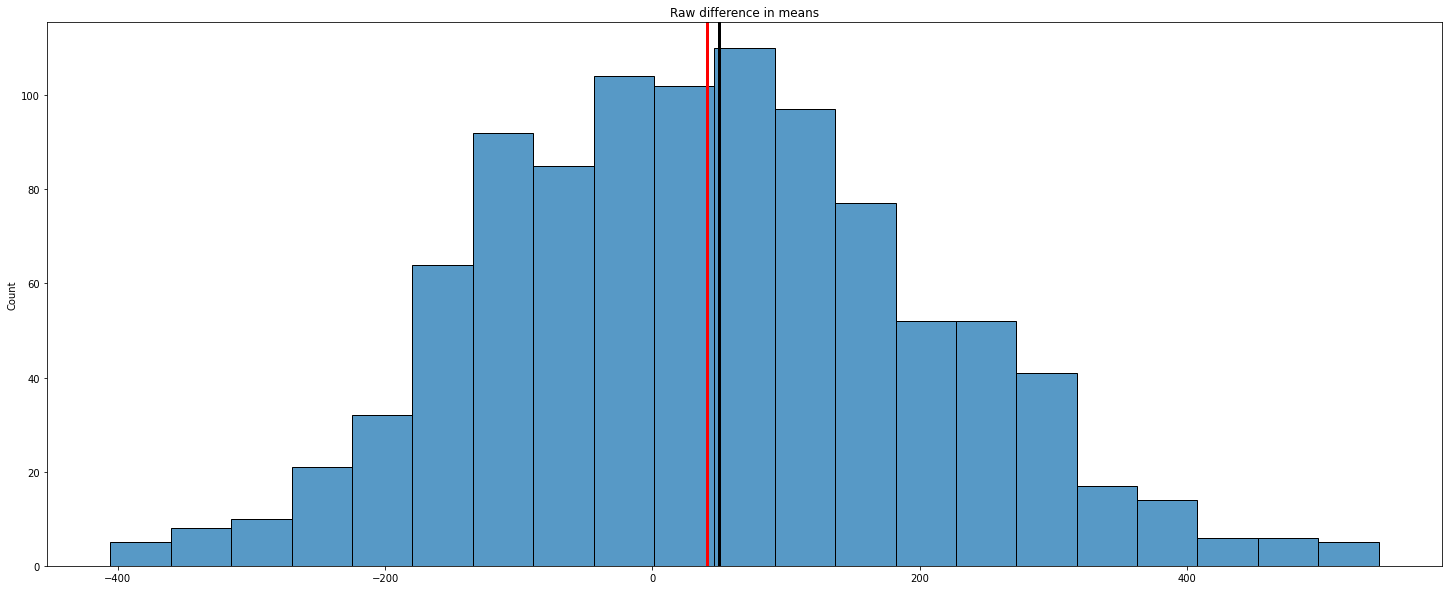

In [ ]:
outputs = [diff_means(get_data_3(N_obs)) for _ in trange(N_sims)]
fig = sns.histplot(outputs)
fig.set_title("Raw difference in means") 
fig.axvline(np.mean(outputs), color="red", linewidth=3)
fig.axvline(true_effect, color="black", linewidth=3)
print(f"Nobs: {N_obs}, Nsim: {N_sims}")
print(f"Mean: {np.mean(outputs)}, SD: {np.std(outputs)}")

### We can get a much more precise answer if we calculate the impact separately by rich/non-rich group

100%|██████████| 1000/1000 [00:02<00:00, 356.30it/s]


Nobs: 1000, Nsim: 1000
Mean: 49.552534828159125, SD: 8.161341839118395


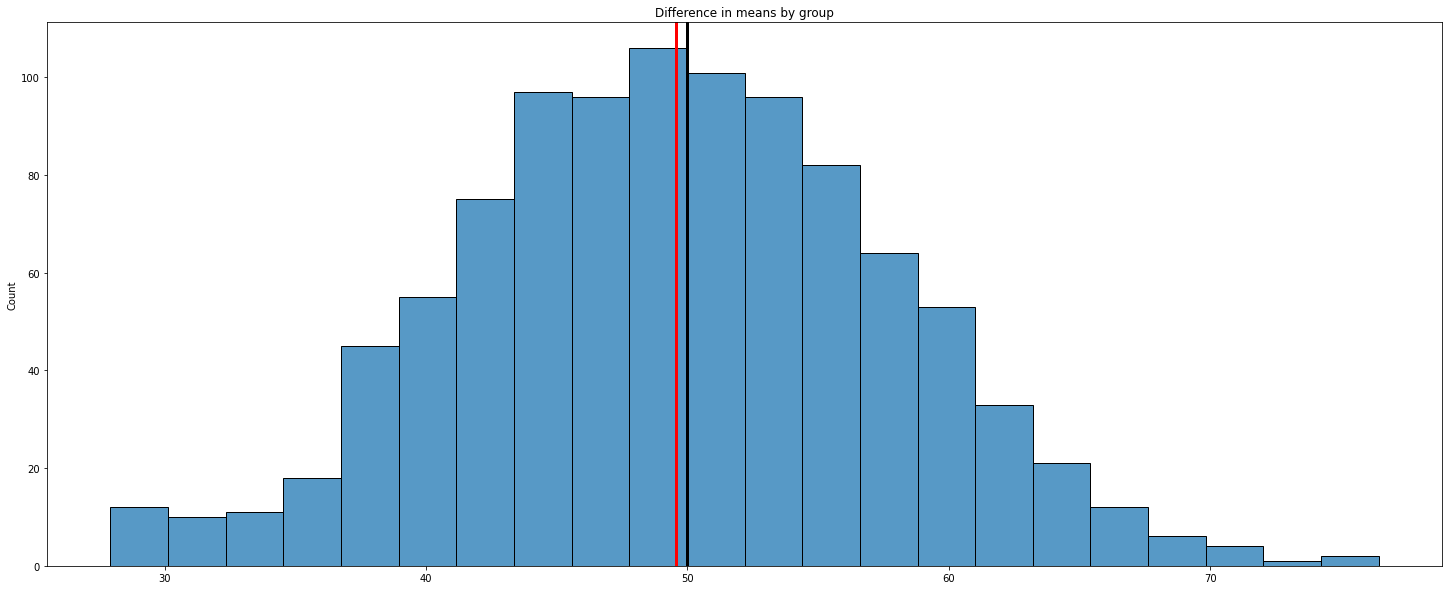

In [ ]:
outputs = [diff_means_by_group(get_data_1(N_obs), "rich") for _ in trange(N_sims)]
fig = sns.histplot(outputs)
fig.set_title("Difference in means by group")
fig.axvline(np.mean(outputs), color="red", linewidth=3)
fig.axvline(true_effect, color="black", linewidth=3)
print(f"Nobs: {N_obs}, Nsim: {N_sims}")
print(f"Mean: {np.mean(outputs)}, SD: {np.std(outputs)}")

## We can still get an unbiased estimate without controlling for Rich
## But it takes more data to get a precise estimate

100%|██████████| 1000/1000 [00:10<00:00, 95.62it/s]


Nobs: 100000, Nsim: 1000
Mean: 49.94080096675306, SD: 17.898463213234688


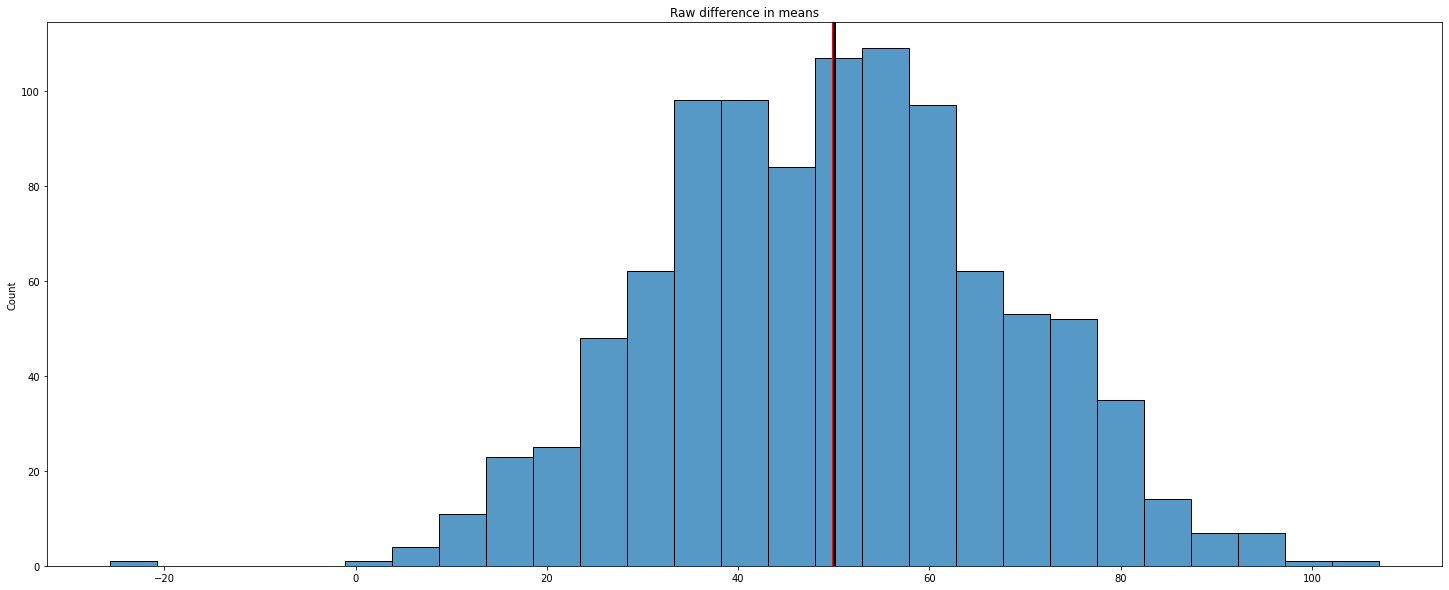

In [ ]:
large_n = 100_000
outputs = [diff_means(get_data_3(large_n)) for _ in trange(N_sims)]
fig = sns.histplot(outputs)
fig.set_title("Raw difference in means") 
fig.axvline(np.mean(outputs), color="red", linewidth=3)
fig.axvline(true_effect, color="black", linewidth=3)
print(f"Nobs: {large_n}, Nsim: {N_sims}")
print(f"Mean: {np.mean(outputs)}, SD: {np.std(outputs)}")

# Automating the process with DoWhy

## A more complex graph

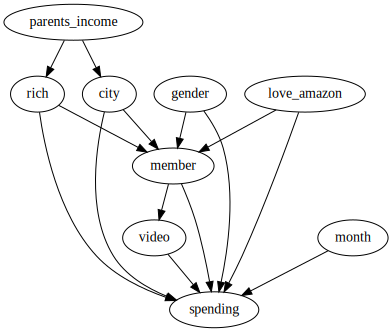

In [ ]:
g = gr.Digraph()
g.edge("parents_income", "rich")
g.edge("parents_income", "city")
g.edge("rich", "member")
g.edge("rich", "spending")
g.edge("gender", "member")
g.edge("gender", "spending")
g.edge("city", "member")
g.edge("city", "spending")
g.edge("love_amazon", "spending")
g.edge("love_amazon", "member")
g.edge("member", "spending")
g.edge("member", "video")
g.edge("video", "spending")
g.edge("month", "spending")
g

In [ ]:
N = 100000
df = simulate(
  rich = lambda: np.random.binomial(1, 0.05, N),
  city = lambda: np.random.binomial(1, 0.05, N),
  gender = lambda: np.random.binomial(1, 0.50, N),
  love_amazon = lambda rich, city: np.random.binomial(1, 0.05 + 0.05*rich + 0.05*city, N),
  member = lambda city, rich, love_amazon, gender: 
    np.random.binomial(1, 0.20 + 0.20*rich + 0.05*city + 0.2*love_amazon + 0.01*gender, N),
  spending = lambda city, rich, love_amazon, gender, member: 
    city*10 + rich*100 + love_amazon*200 + member*50 + gender*10 + np.random.normal(500,100,N),
)
  

In [ ]:
model = CausalModel(
    data = df,
    treatment = 'member',
    outcome = 'spending',
    graph = g.__str__()
)

In [ ]:
estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                        
─────────(Expectation(spending|rich,love_amazon,city,gender))
d[member]                                                    
Estimand assumption 1, Unconfoundedness: If U→{member} and U→spending then P(spending|member,rich,love_amazon,city,gender,U) = P(spending|member,rich,love_amazon,city,gender)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
estimate = model.estimate_effect(estimand, method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['month']}
Causal Estimate is 50.26330098022163


### What if we do not observe love_amazon?

In [ ]:
df.drop("love_amazon", axis=1, inplace=True)
model = CausalModel(
    data = df,
    treatment = 'member',
    outcome = 'spending',
    graph = g.__str__()
)

In [ ]:
estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
estimate = model.estimate_effect(estimand, method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

ERROR:dowhy.causal_model:No valid identified estimand available.


linear_regression
Causal Estimate is None


# Questions for next time
* What happens when I have a large number of groups to control for?